[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ruifcruz/WCARS_2025/blob/main/2.Chat_with_a_pdf_file/2_Chat_with_a_pdf_file.ipynb)


# Generative AI applications with python
@Francisco Cruz - francisco.cruz@iscte-iul.pt

# App 2 - Chat with a PDF file

The objective of the code in this notebook is to communicate with the text of a PDF file. This is achieved by:
- loading the PDF content
- splitting the content into chunks
- storing the chunks on a vector database
- when a user makes a question, similar chunks are retrieved from the database and provided to the model

**Note**: There are several alternatives to OpenAI which provide LLM models with similar quality (Claude, Mistral, Gemini, Deepseek, HuggingFace, etc)

# 0. Preparation steps

In [1]:
# Download and install langchain and other needed packages on the computer
%%capture
!pip install langchain==0.3.24 langchain-community==0.3.23 langchain-openai==0.3.16 gradio==5.29.0 pypdf==5.5.0

In [2]:
# # We need to instruct the computer to access the packages that will be needed along the notebook
# google.colab package is needed to access client secrets (explained on the next cells)
from google.colab import userdata
# langchain packages are needed to load and prepare files, store them on a database and retrieve information from the database
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain import hub
# IPython package is needed to print easier to read outputs
from IPython.display import display, Markdown
import os
# gradio package is needed to deploy a chat interface
import gradio as gr

In [3]:
# Creating a function that will be useful ahead
def print_text(text):
  display(Markdown(text))

To access OpenAI's services, you need to have a password (api key).

To obtain one, you must create an account at https://platform.openai.com/, go to 'API keys' and create a key. You will need to have a payment method associated with your account.

The key can be placed directly in the code, but that is not considered secure. Therefore, in Colab you can use the 'Secrets' tab (on the left), where you can add a line with:
- 'Name' equal to OPENAI_API_KEY
- 'Value' equal to the key"

In [4]:
# The computer will read and store the key that was pasted on the tab "Secrets"
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# 1. Setup the main actors of the RAG system

In [5]:
# Desenho com LLM + vector store

In [6]:
# Create a chat model (this is the main model used on the conversation)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [7]:
# Create an embedding model (this is the model used to convert text into vectors)
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")

In [8]:
# Create a vector store (in this case, we use a simple database in memory)
contract_vector_store = InMemoryVectorStore(embeddings_model)

In [9]:
# Create a prompt to instruct the LLM
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [10]:
# Analyse the prompt text
print_text(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:

# 2. Setup actions of the loading pipeline

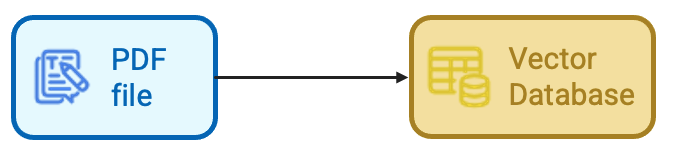

In [11]:
# Create a function that opens a file and returns the contents of that file
def load_docs(file_path):
  loader = PyPDFLoader(file_path=file_path)
  docs = loader.load()
  return docs

In [12]:
# Testing the loader
contract_docs = load_docs("https://raw.githubusercontent.com/ruifcruz/WCARS_2025/main/2.Chat_with_a_pdf_file/source_data/DL 380_2007.pdf")

In [13]:
# We can take a look at the first document (the first page) of the list
contract_docs[1]

Document(metadata={'producer': 'Acrobat Distiller 7.0 (Windows)', 'creator': 'PyPDF', 'creationdate': '2007-11-12T15:13:29+00:00', 'author': 'INCM', 'moddate': '2007-11-12T15:17:36+00:00', 'title': '', 'source': 'https://raw.githubusercontent.com/ruifcruz/WCARS_2025/main/2.Chat_with_a_pdf_file/DL 380_2007.pdf', 'total_pages': 35, 'page': 1, 'page_label': '2'}, page_content='8404  Diário da República, 1.ª série — N.º 218 — 13 de Novembro de 2007 \ndos combustíveis em todos os postos de abastecimento, \nindependentemente da sua localização, através da utili-\nzação de painéis, conforme estabelecido no Decreto -Lei \nn.º 170/2005, de 10 de Outubro.\nDe igual modo, por força do Decreto -Lei n.º 374/2007, \nde 7 de Novembro, ficou consagrado que a EP, S. A., teria \ncomo objec to de actividade a concepção, projecto, constru-\nção, financiamento, conservação, exploração, requalifica-\nção e alargamento da rede rodoviária nacional, sucedendo \nà EP — Estradas de Portugal, E. P. E., em todos o

In [14]:
# Create a function that splits the content of the documents into smaller pieces (chunks)
def split_docs(docs):
  text_splitter = RecursiveCharacterTextSplitter(
      chunk_size=1000,
      chunk_overlap=200,
      add_start_index=True,
  )
  chunks = text_splitter.split_documents(docs)
  return chunks

In [15]:
# Testing the splitting function
contract_chunks = split_docs(contract_docs)
print(f"Document was split into {len(contract_chunks)} chunks.")

Document was split into 247 chunks.


In [16]:
# We can see the content of the tenth chunk
contract_chunks[10]

Document(metadata={'producer': 'Acrobat Distiller 7.0 (Windows)', 'creator': 'PyPDF', 'creationdate': '2007-11-12T15:13:29+00:00', 'author': 'INCM', 'moddate': '2007-11-12T15:17:36+00:00', 'title': '', 'source': 'https://raw.githubusercontent.com/ruifcruz/WCARS_2025/main/2.Chat_with_a_pdf_file/DL 380_2007.pdf', 'total_pages': 35, 'page': 1, 'page_label': '2', 'start_index': 3228}, page_content='Outorga do contrato\nFicam os Ministros de Estado e das Finanças e das Obras \nPúblicas, Transportes e Comunicações autorizados, com a \nfaculdade de delegação, a outorgar, em nome e representa-\nção do Estado, o contrato de concessão, cuja minuta será \naprovada mediante resolução do Conselho de Ministros.\nArtigo 4.º\nAlteração à Lei n.º 10/90, de 17 de Março\nO artigo 15.º da Lei n.º 10/90, de 17 de Março, na re-\ndacção dada pela Lei n.º 3 -B/2000, de 4 de Abril, passa a \nter a seguinte redacção:\n«Artigo 15.º\nConstrução, conservação e exploração de infra -estruturas\n1 — . . . . . . . . .

In [17]:
# Create a function that stores a list of chunks on the database (vector store)
def store_documents(chunks, vector_store):
  vector_store.add_documents(documents=chunks)

In [18]:
# Testing the storage of documents
store_documents(contract_chunks, contract_vector_store)

In [19]:
# As a test, we may try to find two chunks which have a similar meaning to "Contract value"
contract_vector_store.similarity_search("Contract value", k=2)

[Document(id='0b6acc1b-1bc8-488a-b907-bc04b0187a5c', metadata={'producer': 'Acrobat Distiller 7.0 (Windows)', 'creator': 'PyPDF', 'creationdate': '2007-11-12T15:13:29+00:00', 'author': 'INCM', 'moddate': '2007-11-12T15:17:36+00:00', 'title': '', 'source': 'https://raw.githubusercontent.com/ruifcruz/WCARS_2025/main/2.Chat_with_a_pdf_file/DL 380_2007.pdf', 'total_pages': 35, 'page': 20, 'page_label': '21', 'start_index': 3172}, page_content='valores:\na) O valor correspondente a 1  % do orçamento das obras \na realizar nesse ano pela concessionária;\nb) Na data da entrada em serviço de cada uma das vias, \no montante da caução que lhe corresponde é reduzido a \n0,02  % do somatório dos valores da renda anual fixada no \ncontrato de concessão, que ainda não tenham sido pagos.\n4 — Sem prejuízo do disposto no número anterior, a \ncaução tem um valor mínimo de € 2 000 000, o qual é \nactualizado em Janeiro de cada ano, de acordo com o IPC \npublicado para o ano anterior àquele em que a actu

# 3. Setup the actions of the QA pipeline

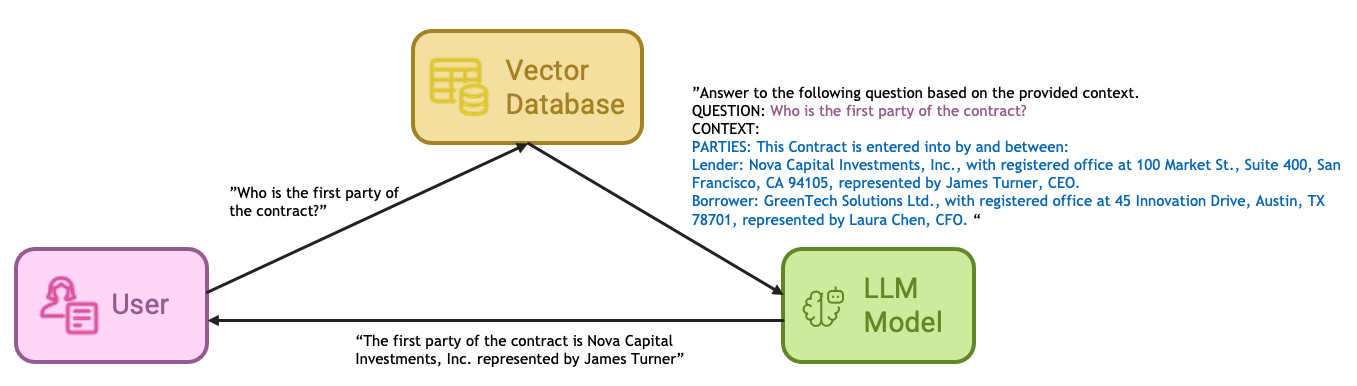

In [20]:
# Create a function to retrieve chunks from the database
def retrieve_vector_store(question, vector_store):
    retrieved_docs = vector_store.similarity_search(question)
    return retrieved_docs

In [21]:
# Create a function to generate an answer
def generate_answer(question, retrieved_docs):
    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
    messages = prompt.invoke({"question": question, "context": docs_content})
    response = llm.invoke(messages)
    return response.content

In [22]:
# Testing the answer generator
question = "What service is the concessionaire required to provide?"
response = generate_answer(question, retrieve_vector_store(question, contract_vector_store))
print_text(response)

The concessionaire is required to provide assistance to highway users, which includes monitoring traffic conditions and accident prevention. Additionally, it must offer sanitary and mechanical assistance and ensure the installation of a telecommunications network along the highways for emergency calls. The concessionaire also needs to maintain service areas that meet safety, hygiene, and quality standards.

In [23]:
# Testing the answer generator
question = "What investment is the concessionaire required to make?"
response = generate_answer(question, retrieve_vector_store(question, contract_vector_store))
print_text(response)

The concessionaire is required to make an investment corresponding to 1% of the annual budget for the works to be carried out. Additionally, there is a minimum guarantee of €2,000,000, which is updated annually according to the previous year's IPC. The concessionaire is also responsible for obtaining the necessary financing to fulfill all contractual obligations.

In [24]:
# Testing the answer generator
question = "What is the object of this concession?"
response = generate_answer(question, retrieve_vector_store(question, contract_vector_store))
print_text(response)

The object of the concession is the financing, conservation, operation, requalification, and expansion of the roads that are part of the National Road Network. Additionally, it includes the design, construction, and related services for the same roads. This encompasses various facilities, maintenance centers, and equipment essential for the exploitation and upkeep of the infrastructure.

# 4. Build a chat interface

In [26]:
chat_interface_vector_store = InMemoryVectorStore(embeddings_model)

In [29]:
# We can now use the functions that were created on the previous cells and put everything together
def answer(message, history):
    print(f"message: {message}")

    # If a file was uploaded, its contents need to be loaded to the database
    if len(message["files"]) > 0:
        docs = []
        for file in message["files"]:
            # For each file, load the contents
            docs = docs + load_docs(file)
        # Split the documents contents
        chunks = split_docs(docs)
        # Store the chunks
        store_documents(chunks, chat_interface_vector_store)

    # Retrieve the relevant documents from the database
    retrieved_docs = retrieve_vector_store(message["text"], chat_interface_vector_store)
    # Provide the documents and generate an answer
    response = generate_answer(message["text"], retrieved_docs)
    return response

In [30]:
# We can use gradio to easily create a chat interface and launch it
demo = gr.ChatInterface(
    answer,
    type="messages",
    title="WCARS RAG Chatbot",
    description="Upload pdf files and ask questions about them!",
    textbox=gr.MultimodalTextbox(file_types=[".pdf"]),
    multimodal=True
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4f096521aae067ff2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
